<a href="https://colab.research.google.com/github/Rohit1217/VGAN/blob/main/GANfc.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import matplotlib.pyplot as plt
import numpy as np

import torch,torchvision
from torch.utils.data import DataLoader,TensorDataset
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets,transforms

In [2]:
trainset = datasets.MNIST('~/.pytorch/MNIST_data/', download=True, train=True)

data=trainset.data
data=data.to(dtype=torch.float32)
norm = transforms.Normalize((128,),(128,))
data=norm(data)
#data=data*0.5+0.5

data_target=trainset.targets.to(dtype=torch.float32)
#data_target
data=data.view(60000,784)
data=data.to(dtype=torch.float32)
#data_target=data_target.view(60000,1,28,28)

trainset=TensorDataset(data,data)
trainloader=DataLoader(trainset,batch_size=64,shuffle=True)

100%|██████████| 9912422/9912422 [00:00<00:00, 368242750.36it/s]

Extracting /root/.pytorch/MNIST_data/MNIST/raw/train-images-idx3-ubyte.gz to /root/.pytorch/MNIST_data/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 76042494.55it/s]


Extracting /root/.pytorch/MNIST_data/MNIST/raw/train-labels-idx1-ubyte.gz to /root/.pytorch/MNIST_data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 135856115.13it/s]

Extracting /root/.pytorch/MNIST_data/MNIST/raw/t10k-images-idx3-ubyte.gz to /root/.pytorch/MNIST_data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 3098150.72it/s]


Extracting /root/.pytorch/MNIST_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to /root/.pytorch/MNIST_data/MNIST/raw



In [3]:
Device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
l=10

In [4]:
class generator(nn.Module):
  def __init__(self):
    super(generator,self).__init__()
    z=8
    l=100
    self.fc1=nn.Linear(l,32*z)
    self.fc3=nn.Linear(32*z,64*z)
    self.fc4=nn.Linear(64*z, 128*z)
    self.fc5=nn.Linear(128*z,784)

    self.bn1=nn.BatchNorm1d(16*z,0.8)
    self.bn2=nn.BatchNorm1d(32*z,0.8)
    self.bn3=nn.BatchNorm1d(64*z,0.8)
    self.bn4=nn.BatchNorm1d(128*z,0.8)

  def forward(self,b):
    x=torch.randn(b,100).to(Device)
    x=F.leaky_relu(self.bn2(self.fc1(x)),0.2,inplace=True)
    #x=F.leaky_relu(self.bn2(self.fc2(x)),0.2,inplace=True)
    x=F.leaky_relu(self.bn3(self.fc3(x)),0.2,inplace=True)
    x=F.leaky_relu(self.bn4(self.fc4(x)),0.2,inplace=True)
    x=F.tanh(self.fc5(x))
    return x
gen=generator().to(Device)
y=gen(2)
y.shape

torch.Size([2, 784])

In [5]:
class discriminator(nn.Module):
  def __init__(self):
    super(discriminator,self).__init__()
    z=8
    self.fc1=nn.Linear(784,64*z)
    self.fc2=nn.Linear(64*z,32*z)
    self.fc3=nn.Linear(32*z,1)
    self.fc4=nn.Linear(4*z,1)

    self.bn2=nn.BatchNorm1d(32*z)
    self.bn3=nn.BatchNorm1d(4*z)
    self.bn4=nn.BatchNorm1d(z)

  def forward(self,x):
    x=F.leaky_relu(self.fc1(x),0.2,True)
    x=F.leaky_relu(self.bn2(self.fc2(x)),0.2,True)
    #x=F.leaky_relu(self.bn3(self.fc3(x)),0.2,True)
    #x=F.relu(self.bn4(self.fc4(x)))
    x=F.sigmoid(self.fc3(x))
    x=x.view(-1)
    return x
disc=discriminator().to(Device)
disc(y)

tensor([0.4828, 0.5438], grad_fn=<ViewBackward0>)

In [6]:
epochs=100
gen=generator().to(Device)
disc=discriminator().to(Device)
optimizer=optim.Adam(gen.parameters(),lr=0.0002,betas=(0.5,0.999))
optimizer2=optim.Adam(disc.parameters(),lr=0.0002,betas=(0.5,0.999))
criterion=nn.BCELoss()

In [7]:
for epoch in range(epochs):
  disc_loss=0
  gen_loss=0
  count=0
  for input,_ in trainloader:
    input=input.to(Device)
    b,c=input.shape

    optimizer2.zero_grad()

    real_label=torch.ones(b).to(Device)
    real_out=disc(input)
    loss_d_real=criterion(real_out,real_label)
    #loss_d_real.backward()

    fake_label=torch.zeros(b).to(Device)
    fake_input=gen(b)
    fake_out=disc(fake_input)
    loss_d_fake=criterion(fake_out,fake_label)
    #loss_d_fake.backward()
    loss1=(loss_d_real+loss_d_fake)/2

    disc_loss+=loss_d_real+loss_d_fake
    loss1.backward()
    optimizer2.step()



    optimizer.zero_grad()
    y=gen(b)
    label=torch.ones(b).to(Device)
    gen_out=disc(y)
    loss_gen=criterion(gen_out,label)
    gen_loss+=loss_gen.item()
    #print(loss_gen)
    #print(real_label,fake_label,label,real_out,fake_out,gen_out)

    loss_gen.backward()
    optimizer.step()

    count+=1



    #print(disc_loss,gen_loss)

  print(f'epoch={epoch},total_gen_loss={gen_loss},total_disc_loss={disc_loss},mean_gen_loss={gen_loss/count},mean_disc_loss={disc_loss/count}')



epoch=0,total_gen_loss=1008.6972041726112,total_disc_loss=901.3109130859375,mean_gen_loss=1.0753701537021443,mean_disc_loss=0.9608858227729797
epoch=1,total_gen_loss=1204.189378798008,total_disc_loss=767.8662719726562,mean_gen_loss=1.2837839859253817,mean_disc_loss=0.8186207413673401
epoch=2,total_gen_loss=1194.7725402712822,total_disc_loss=795.3204345703125,mean_gen_loss=1.2737447124427315,mean_disc_loss=0.8478896021842957
epoch=3,total_gen_loss=1206.8549070358276,total_disc_loss=812.9728393554688,mean_gen_loss=1.286625700464635,mean_disc_loss=0.8667087554931641
epoch=4,total_gen_loss=1206.723650276661,total_disc_loss=831.2531127929688,mean_gen_loss=1.2864857678855661,mean_disc_loss=0.8861973285675049


KeyboardInterrupt: 

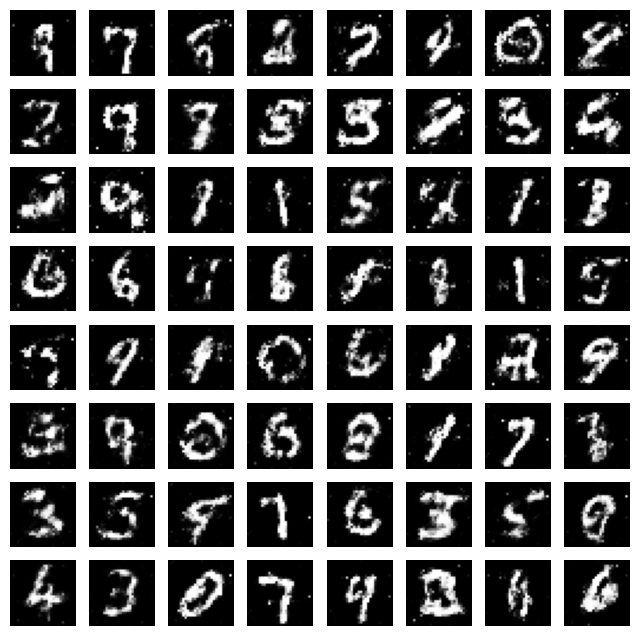

In [8]:
with torch.no_grad():
  #gen.eval()
  z=gen(128)
  z=z[:64]
  x = z.view(8, 8, 28, 28)
  x = x.to('cpu')
  image_np = x.numpy()

  # Create a figure and a set of subplots arranged in an 8x8 grid
  fig, axes = plt.subplots(8, 8, figsize=(8, 8))

  # Iterate through the subplots and display each image
  for i in range(8):
      for j in range(8):
          axes[i, j].imshow(image_np[i, j], cmap='gray')
          axes[i, j].axis('off')  # Turn off axis labels

  plt.show()

In [9]:
#z=data[:128].to(Device)
y=disc(z)
y

tensor([0.1887, 0.3499, 0.1377, 0.2758, 0.1369, 0.2466, 0.3503, 0.1374, 0.2920,
        0.3359, 0.3349, 0.2279, 0.5124, 0.0809, 0.2535, 0.4005, 0.3045, 0.3168,
        0.3326, 0.2222, 0.2082, 0.2919, 0.4063, 0.2825, 0.2551, 0.2731, 0.4122,
        0.2727, 0.2797, 0.5194, 0.4891, 0.4820, 0.4838, 0.4096, 0.2350, 0.8174,
        0.2976, 0.2936, 0.2141, 0.3228, 0.1274, 0.2088, 0.3461, 0.2736, 0.2140,
        0.2030, 0.0376, 0.3339, 0.3139, 0.1910, 0.3676, 0.3476, 0.4377, 0.1921,
        0.1800, 0.3534, 0.3055, 0.4242, 0.1744, 0.7272, 0.1882, 0.3574, 0.0865,
        0.1689], grad_fn=<ViewBackward0>)